## Computing the power spectral density

In order to compute the average bandpower in the delta band, we first need to compute an estimate of the power spectral density. The most widely-used method to do that is the Welch's periodogram, which consists in averaging consecutive Fourier transform of small windows of the signal, with or without overlapping. 

A classic periodogram requires the spectral content of the signal to be stationnary (i.e. time-unvarying) over the time period considered. Because it is never the case, the periodogram is generally biased and contains way too much variance (see the end of this tutorial). By averaging the periodograms obtained over short segments of the windows, the Welch's method allows to drastically reduce this variance. This comes at the cost, however, of a lower frequency resolution.


$$ F_{res} = \frac{F_s}{N} = \frac{F_s}{F_st} = \frac{1}{t} $$

How do we define the optimal window duration then? 

A commonly used approach is to take a window sufficiently long to encompasses at least two full cycles of the lowest frequency of interest.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(font_scale=1.2)

In [2]:
path = "/Users/ecem/Desktop/phonocardiogram/data/MV/present"

In [3]:
waves = np.load(path + "/present_MV_waves_10sec.npy", allow_pickle= True)

In [4]:
n = waves.shape[0]

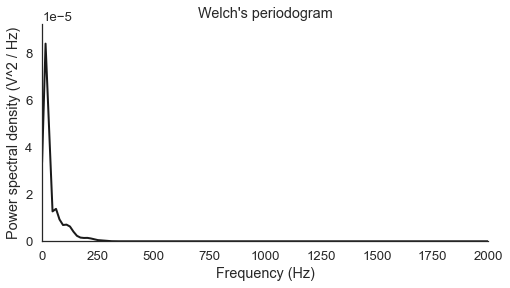

In [5]:
from scipy import signal
freqs, psd = signal.welch(waves[0], 4000)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()

The freqs vector contains the x-axis (frequency bins) and the psd vector contains the y-axis (power spectral density)

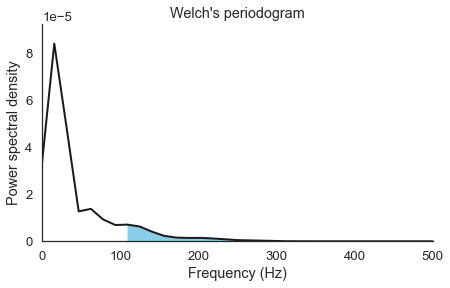

In [6]:
# Define delta lower and upper limits
low, high = 100, 400

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density')
plt.xlim([0, 500])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

The absolute delta power is equal to the blue area of the previous plot. As there is no closed-form formula to integrate this area, we need to approximate it. 

In [7]:
from scipy.integrate import simps

# Frequency resolution
freq_res = 0.1

# Compute the absolute power by approximating the area under the curve
delta_power = simps(psd[idx_delta], dx=freq_res)
print('Absolute power: %.3f' % delta_power)

Absolute power: 0.000


In [8]:
import scipy 

def bandpower(x, fs, fmin, fmax):
    f, Pxx = scipy.signal.periodogram(x, fs=fs)
    ind_min = np.argmax(f > fmin) - 1
    ind_max = np.argmax(f > fmax) - 1
    return np.trapz(Pxx[ind_min:ind_max], f[ind_min:ind_max])

In [9]:
bp = np.zeros((n))
for i in range(n):
    bp[i] = bandpower(waves[i], 4000, 100, 400)

## Fractal dimenasion

In [10]:
import antropy as an

### petrosian :

In [11]:
pt_frac = np.zeros((n))
for i in range(n):
    pt_frac[i] = an.petrosian_fd(waves[i])

### katz :

In [12]:
katz_frac = np.zeros((n))
for i in range(n):
    katz_frac[i] = an.katz_fd(waves[i])

### higuchi :

In [13]:
h_frac = np.zeros((n))
for i in range(n):
    h_frac[i] = an.higuchi_fd(waves[i])

### deterended fluctuation :

In [14]:
df_frac = np.zeros((n))
for i in range(n):
    df_frac[i] = an.detrended_fluctuation(waves[i])

## create their dataframe

In [15]:
import pandas as pd

In [16]:
bandpower_df = pd.DataFrame(bp, columns =["bandpower"])
bandpower_df.head()

,bandpower
0,0.000467
1,0.000079
2,0.000011
3,0.000607
4,0.000077


In [17]:
p_df = pd.DataFrame(pt_frac, columns =["petrosian f.a."])
p_df.head()

,petrosian f.a.
0,1.003023
1,1.002921
2,1.002958
3,1.003153
4,1.003035


In [18]:
k_df = pd.DataFrame(katz_frac, columns =["katz f.a."])
k_df.head()

,katz f.a.
0,1.664540
1,2.121635
2,1.943695
3,1.568108
4,2.185295


In [19]:
h_df = pd.DataFrame(h_frac, columns =["higuchi f.a."])
h_df.head()

,higuchi f.a.
0,1.096912
1,1.097665
2,1.085673
3,1.090975
4,1.109614


In [20]:
df_df = pd.DataFrame(df_frac, columns =["deterended fluctuations f.a."])
df_df.head()

,deterended fluctuations f.a.
0,0.963840
1,0.917476
2,1.045490
3,0.748099
4,0.919040


In [21]:
df = pd.concat([bandpower_df, p_df, k_df, h_df, df_df], axis =1)

In [22]:
df.to_csv("/Users/ecem/Desktop/phonocardiogram/data/MV/present/MV-mock-features.csv" )